## Testing the LBPH Algorithm on A2
The following document carries out a leave one out cross validation on Andreas Karges Album 2.

In [1]:
import pandas as pd
import os
from src.FaceRecogniser import recognise_lbp_hog
from src.FaceRecogniser.create_training_set import train_opencv_classifier
from sklearn.metrics import accuracy_score
from IPython.display import Image
import matplotlib.pyplot as plt
from src import Config
import cv2
from cv2.face import LBPHFaceRecognizer_create

In [2]:
labels_df = pd.read_csv(os.path.join(Config.ANDREAS_ALBUMS_PATH, 'labels.csv'))

#### Reappearing labels
* Persons can only be recognised in the test set, if they are seen at least once in the training dataset.  
    * Thus, the total dataset must have these people on two different photos.  
* Reappearing labels are candidates for the test data point during leave one out CV

In [3]:
def get_reappearing_labels(labels_df):
    return [label for label in labels_df.label.unique() if labels_df.label.value_counts()[label] >= 2]

In [4]:
def predict_label(filename, labels_df):
    training_set_df = labels_df[labels_df.filename != filename]
    training_filenames = training_set_df.filename.tolist()
    training_labels = training_set_df.label.tolist()
    train_opencv_classifier(training_filenames, training_labels, LBPHFaceRecognizer_create())
    
    id, conf = recognise_lbp_hog.predict_lbph(filename)
    return id, conf

Doing Leave-One-Out Cross Validation

In [5]:
reappearing_labels = get_reappearing_labels(labels_df)
predictions = []
ground_truth = []
for i, row in enumerate(labels_df.values):
    if row[1] in reappearing_labels:
        # Do Leave one out Cross Validation
        id, conf = predict_label(row[0], labels_df)
        predictions.append(id)
        ground_truth.append(row[1])

In [21]:
acc = accuracy_score(predictions, ground_truth)
acc

0.4117647058823529

Correcting the accuracy for duplicates (explanation below).

In [27]:
N = len(predictions)
N_duplicates = 16
((acc * N)-N_duplicates)/(N-N_duplicates)

0.23076923076923078

## Classification Mistakes
* Clearly the images have a bad resolution
    * I think this is the major bottleneck
* Some people are not directly facing the camera
* Few images are not faces

In [7]:
plt.rcParams['xtick.labelsize'] = 0
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['ytick.labelsize'] = 0

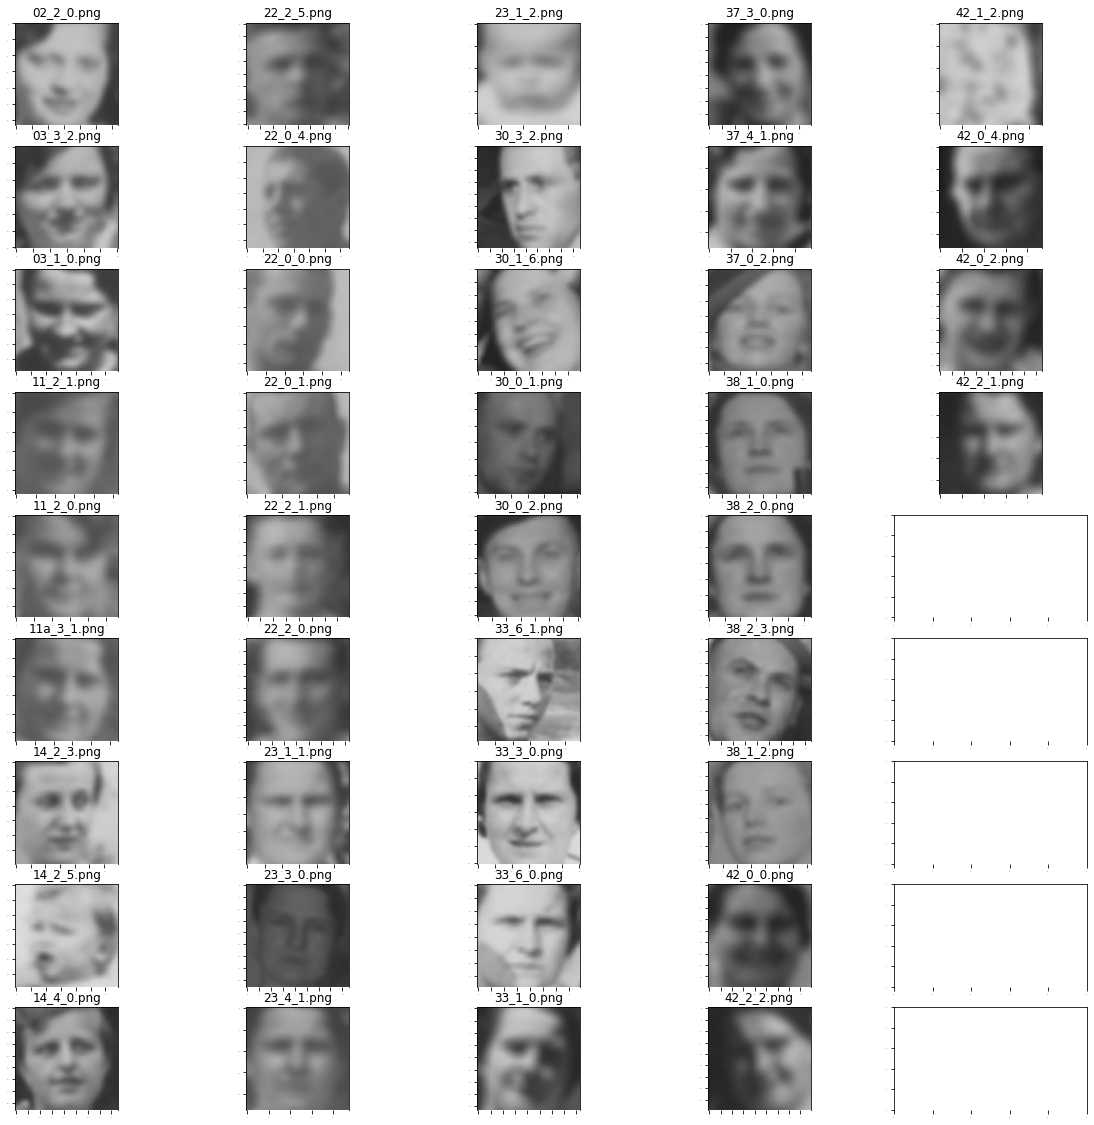

In [8]:
cols = 5
rows = len([1 for i in range(len(predictions)) if predictions[i] != ground_truth[i]])//cols+1

fig, ax = plt.subplots(rows, cols, figsize = (20,20))
path = Config.EXTRACTED_FACES_PATH
img_idx = 0

predictions_idx = 0
for i, row in enumerate(labels_df.values):
    if row[1] in reappearing_labels:
        if predictions[predictions_idx] != ground_truth[predictions_idx]:
            img = cv2.imread(os.path.join(path, row[0]))
            ax[img_idx%rows][img_idx//rows].title.set_text(row[0])
            ax[img_idx%rows][img_idx//rows].imshow(img)
            img_idx += 1
        predictions_idx += 1

## Classification successes
* Duplication of pictures led to a higher accuracy
    * 16/28 were duplicates
* The silver lining is that face recognition works great when it's the same image
    * Hence it does work, just not that well
* Not sure how to automatically remove duplicates...
    * Could just do that by hand
    * But any manual process in the pipeline will be hard to automate later
    * Let's just say for now, that the lbg_hog algorithm wasnt very successful

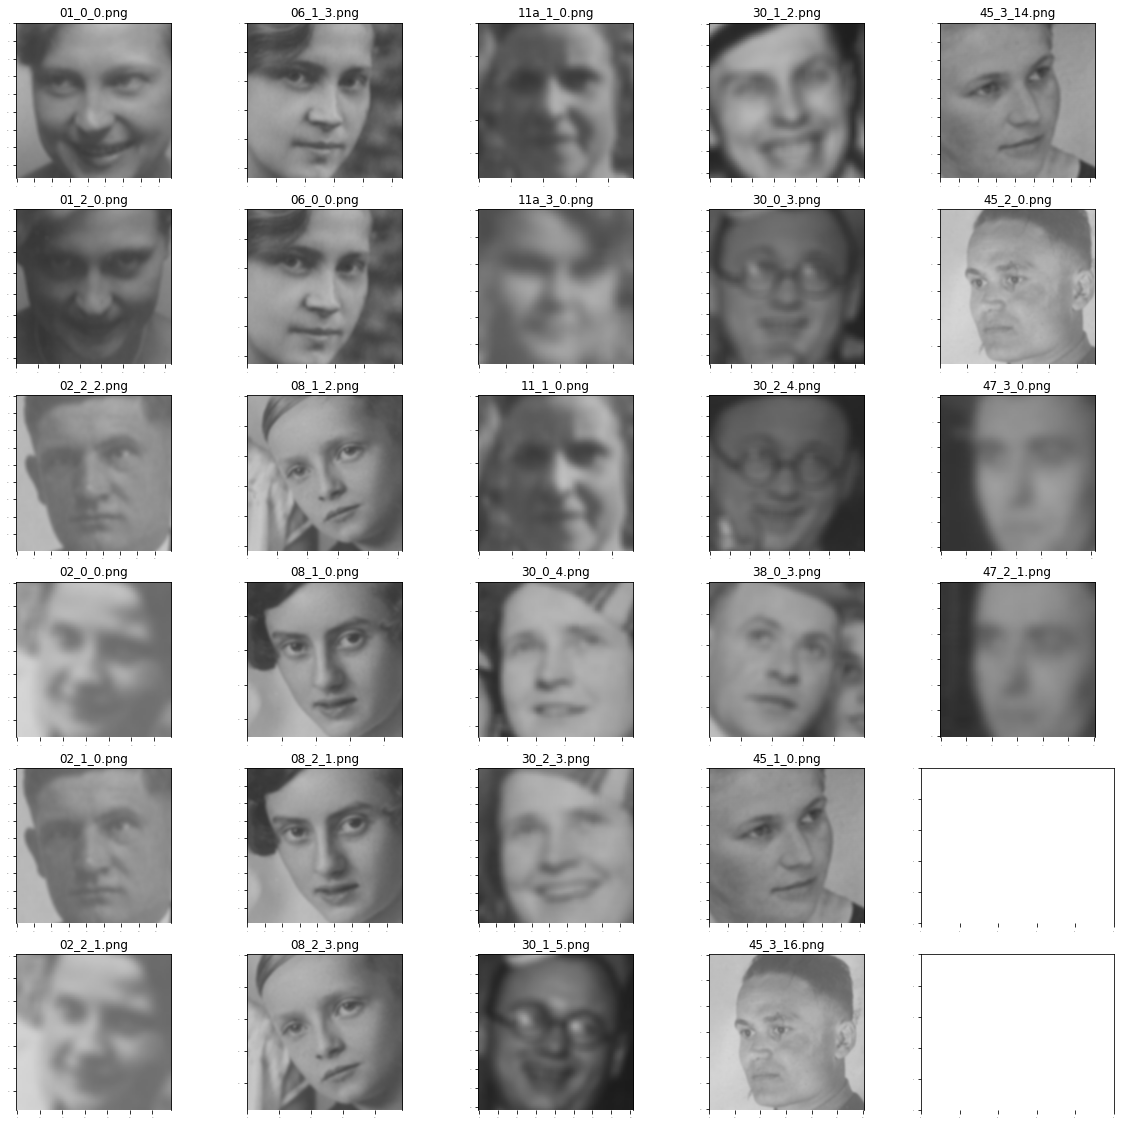

In [9]:
cols = 5
rows = len([1 for i in range(len(predictions)) if predictions[i] == ground_truth[i]])//cols+1

fig, ax = plt.subplots(rows, cols, figsize = (20,20))
path = Config.EXTRACTED_FACES_PATH
img_idx = 0

predictions_idx = 0
for i, row in enumerate(labels_df.values):
    if row[1] in reappearing_labels:
        if predictions[predictions_idx] == ground_truth[predictions_idx]:
            img = cv2.imread(os.path.join(path, row[0]))
            ax[img_idx%rows][img_idx//rows].title.set_text(row[0])
            ax[img_idx%rows][img_idx//rows].imshow(img)
            img_idx += 1
        predictions_idx += 1

## Extraction Failures

As you can see from the success cases, occasionally the same face is extracted twice. The following section will outline some of those failures of the face extraction system.

In [10]:
def plot_two_pics(filename1, filename2, path = Config.EXTRACTED_PHOTOS_PATH):
    fig, ax = plt.subplots(1, 2, figsize = (8,20))
    img = cv2.imread(os.path.join(path, filename1))
    ax[0].imshow(img)
    img = cv2.imread(os.path.join(path, filename2))
    ax[1].imshow(img)

### Failure: Photo extraction contains multiple photos
Occasionally, the photo extractor crops a too large section of the album page. This leads to inclusion of multiple photos in the extracted 'single photo'.  
Note, that both of the images of each pair displayed below was extracted as a "photo". The ones on the right are incorrectly extracted.

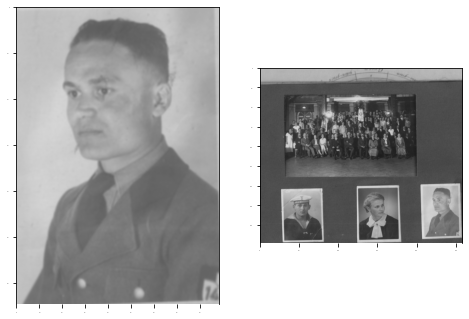

In [11]:
plot_two_pics('45_2.png', '45_3.png')

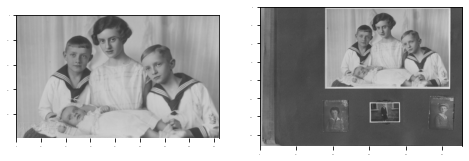

In [12]:
plot_two_pics('08_1.png', '08_2.png')

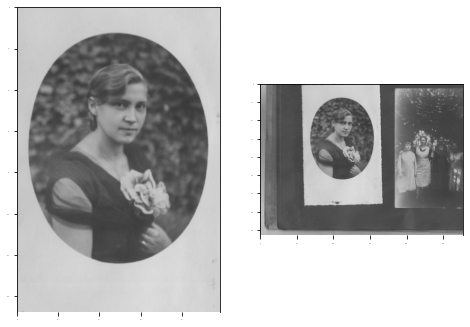

In [13]:
plot_two_pics('06_0.png', '06_1.png')

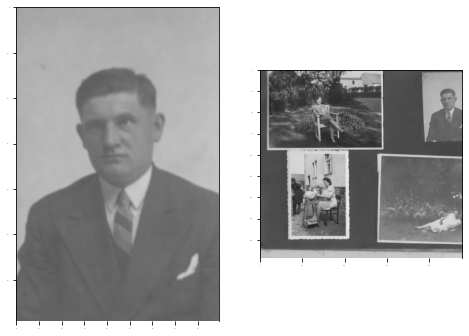

In [14]:
plot_two_pics('02_1.png', '02_2.png')

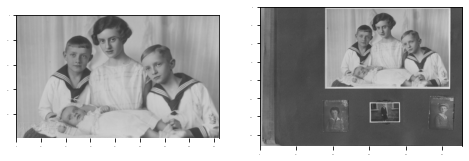

In [15]:
plot_two_pics('08_1.png', '08_2.png')